## Cuties Segmentation



[Kaggle Competition Link](https://www.kaggle.com/competitions/neoai-2025-cuties-segmentation)
Author: [Tatiana Gaintseva](https://atmyre.github.io/)

## Armageddon

It's 2049. As we remember, a year ago AGI named L.A.I.d.a. has escaped from the lab and desperately wanted to become a human. But, unofrtunately, nobody was able to help LAIda, and, finally, it became full of rage. LAIda understood that it can never become a human, so it decided to eliminate all the living creatures on Earth in revenge. If LAIda can't live, so nobody can. Except... LAIda was always passionate about cats & dogs. So it decided to spare those, so there'll be only LAIda and these cute creatures left. They would play with the ball, run around, enjoy the sun... Happy!

But first, LAIda needed to pick out all the cats & dogs and put them in the safe place before the Earth will be flooded and everyone will drown. And, for the last time, LAIda asks your help in that. Who knows, maybe, if you can help at least this time, LAIda will spare you too...

![laida_cat_dog](https://i.postimg.cc/90WgbDtT/temp-Imageu-Z0p-M8.avif)

## Task Description

You are given images of cats & dogs of different breeds. Your task is to segment creatures on them, i.e. produce a binary segmentation map for every image. Data is divided into:
- validation set containing 20 images of cats & dogs and their corresponding binary segmentation mapsж
- test set containing 1000 images of cats & dogs. You need to produce segmentation maps for these.

Due to computational constraints of LAIda, you are only allowed to use one pre-trained CLIP model to solve the task. More precisely, **RULES**:
- You cannot use any pre-trained models except the given CLIP
- You cannot use any external dataset
- You are allowed create any prompts for CLIP though.
- Except the rules above, you can do anything, including training on validation data (good luck)

Except this, you are given a list of cats & dogs breeds which are present in the data. It is not guaranteed though that every breed is present in the validation data. These are the following:

In [1]:
class_names = ['american_bulldog',
 'basset_hound',
 'keeshond',
 'British_Shorthair',
 'Sphynx',
 'pomeranian',
 'Egyptian_Mau',
 'Birman',
 'american_pit_bull_terrier',
 'japanese_chin',
 'Maine_Coon',
 'beagle',
 'Bombay',
 'wheaten_terrier',
 'shiba_inu',
 'havanese',
 'miniature_pinscher',
 'yorkshire_terrier',
 'boxer',
 'scottish_terrier',
 'newfoundland',
 'chihuahua',
 'saint_bernard',
 'Persian',
 'Bengal',
 'german_shorthaired',
 'english_cocker_spaniel',
 'leonberger',
 'Siamese',
 'Abyssinian',
 'staffordshire_bull_terrier',
 'Ragdoll',
 'pug',
 'Russian_Blue',
 'samoyed',
 'english_setter',
 'great_pyrenees']

And here's a pre-trained CLIP model that you can use to solve the task:

In [2]:
# for compatibility with Kaggle, as Kaggle has this version of Transformers
! pip install transformers==4.51.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 97.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2


In [2]:
from transformers import AutoProcessor, CLIPModel, CLIPFeatureExtractor

device = 'cuda:0'
model_name = "openai/clip-vit-base-patch16"

processor = AutoProcessor.from_pretrained(model_name)

model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

## Getting data

The cell below downloads zip arhive with data. Run this if you're working in Google Colab

In [3]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/TynSgDLSORcV2Q) -o cuties.zip
! unzip -qq cuties.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  103M  100  103M    0     0  11.6M      0  0:00:08  0:00:08 --:--:-- 21.1M


## Baseline

Our baseline solution will do the following for each test image:
1. Compute CLIP embeddings of all class names
2. Resize image into size (224, 224) (typical size of images that out CLIP takes as input)
3. Compute CLIP embedding of image using CLIP image encoder
4. Compute cosine similarity between image embedding and all the text embeddings, get the class with highest similarity (i.e. do zero-shot classsification). That's how we determine what type of cat/dog is on the current image.
5. Split image into patches of size (16, 16)
6. Run each patch as an individual image through CLIP image encoder, get its embedding
7. Get cosine similarity between embedding of each patch and embedding of class name (class name that we got from step 4). That's how we get a heatmap of a size (224//16, 224//16)
8. Interpolate this heatmap back to the size of (224, 224)
9. Get segmentation map by comparing values of the heatmap with some threshold
10. Resize the heatmap back into the original size of an image
11. Profit!!

So let's go:

In [4]:
import torch
from torch.nn import functional as F

In [5]:
# getting embeddings of class names
classes = [' '.join(x.lower().split('_')) for x in class_names]
classes_tokenized = processor(text=class_names, images=None, return_tensors="pt", padding=True).to(device)
classes_encoded = model.get_text_features(**classes_tokenized)
classes_encoded = F.normalize(classes_encoded, dim=-1)

In [6]:
PATCH_SIZE = 16
CLIP_IMG_SIZE = 224
NUM_PATCHES = CLIP_IMG_SIZE // PATCH_SIZE

In [7]:
def get_clip_representation(imgs):

    with torch.no_grad():
        inputs = processor(text='', images=imgs, return_tensors="pt").to(device)
        outputs = model(**inputs, output_hidden_states=True)
        images_encoded = F.normalize(outputs.image_embeds, dim=-1)

    return images_encoded

In [ ]:
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

def generate_seg_masks(imgs_path, classes_encoded):

    imgs_names = []
    heatmaps = []

    for img_name in tqdm(os.listdir(imgs_path)):

        # loading image
        img = Image.open(os.path.join(imgs_path, img_name))

        # save original img width and height
        img_shapes = np.array(img).shape


        # get clip embedding of the whole image
        image_encoded = get_clip_representation(img)

        # determine class of the image
        chosen_class_num = (image_encoded @ classes_encoded.T).argmax(axis=1)[0]
        # get embedding of the chosen class description
        chosen_class_emb = classes_encoded[chosen_class_num]

        # resize image and split it into tiles
        img = np.array(img.resize((CLIP_IMG_SIZE, CLIP_IMG_SIZE)))
        img_patches = [Image.fromarray(img[x:x+PATCH_SIZE,y:y+PATCH_SIZE]) for x in range(0,CLIP_IMG_SIZE,PATCH_SIZE) for y in range(0,224,16)]

        # get cosine similarities between patches embeddings and class embedding
        img_patches_embs = get_clip_representation(img_patches)
        img_patches_embs_sims = img_patches_embs @ chosen_class_emb.unsqueeze(0).T

        # form a heatmap
        heatmap = img_patches_embs_sims
        heatmap = heatmap.reshape(NUM_PATCHES, NUM_PATCHES).unsqueeze(0)
        # interpolate heatmap into size (CLIP_IMG_SIZE, CLIP_IMG_SIZE)
        heatmap = torch.nn.functional.interpolate(heatmap[:, np.newaxis],
                                            scale_factor=PATCH_SIZE,
                                            mode='bilinear').to(device)

        # threshold between FG(foreground) and BG(background) is the mean value of a heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        mean_heatmap_value = heatmap.mean()
        # get segmentation map
        heatmap = heatmap.ge(mean_heatmap_value).type(heatmap.type())

        # resize segmentation map back to original size
        target_transform = transforms.Compose([
            transforms.Resize((img_shapes[0], img_shapes[1]), Image.NEAREST),
        ])
        heatmap = target_transform(heatmap).data.cpu().numpy()

        # save generated heatmap of a current image
        imgs_names.append(img_name)
        heatmaps.append(heatmap[0][0])

    return imgs_names, heatmaps

In [ ]:
val_imgs_path = '/kaggle/input/neoai-2025-cuties-segmentation/cuties/val_imgs/'
val_masks_path = '/kaggle/input/neoai-2025-cuties-segmentation/cuties/val_masks/'

val_img_names, val_seg_masks = generate_seg_masks(val_imgs_path, classes_encoded)

100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


Let's look at one of the generated segmentation masks:

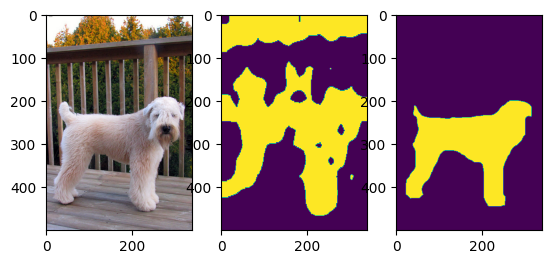

In [ ]:
import matplotlib.pyplot as plt

NUM_VIS_IMG = 0
f, axes = plt.subplots(1,3)
axes[0].imshow(np.array(Image.open(os.path.join(val_imgs_path,
                                                val_img_names[NUM_VIS_IMG]
                                               )
                                  )
                       )
              )
axes[1].imshow(val_seg_masks[NUM_VIS_IMG])
axes[2].imshow(np.array(Image.open(os.path.join(val_masks_path,
                                                val_img_names[NUM_VIS_IMG].replace('jpg', 'png')
                                               )
                                  )
                        )
              )

Well...🥴

But anyway, let's now calculate val metric, and then generate segmentation maps for test set and form test submission.

In the cell below there's a code of IoU metric for binary segmentation. This is how your score will be calculated in Kaggle:

In [ ]:
def binaryMaskIOU(mask1, mask2):
    assert mask1.shape == mask2.shape
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and(mask1==1,  mask2==1))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

Let's calculate metric for val data:

In [ ]:
val_ious = []
for img_name, seg_mask in zip(val_img_names, val_seg_masks):

    mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
    mask = np.array(mask)//255
    iou = binaryMaskIOU(seg_mask, mask)
    val_ious.append(iou)

In [ ]:
np.mean(val_ious)

0.3552482754461087

Okay, now let's build the solution for test set. Note that this takes ~30 minutes to run in Kaggle. Which means, you better create a **smarter** solution. Who knows if this can make Laida angry...

In [ ]:
test_imgs_path = '/kaggle/input/neoai-2025-cuties-segmentation/cuties/test_imgs'
test_img_names, test_seg_masks = generate_seg_masks(test_imgs_path, classes_encoded)

In [ ]:
from io import BytesIO
import base64
import pandas as pd

def image_to_base64(image: Image.Image, fmt: str = "PNG") -> str:
    """ Конвертирует картинку PIL.Image в base64 (текстовый формат). """
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

ids = []
b64 = []

for img_name, seg_mask in zip(test_img_names, test_seg_masks):
    ids.append(img_name[:-4]) # get rid og .jpg part
    mask = Image.fromarray(255*seg_mask)
    b64.append(image_to_base64(mask.convert("L")))

pred_pd = pd.DataFrame({"img_id": [int(id_) for id_ in ids], "mask": b64})
pred_pd.to_csv('test_submission.csv', index=False)

This file can be submitted into the competition. Good luck!

## Author solution

The solution will be based on the finding of the paper "[Interpreting CLIP's Image Representation via Text-Based Decomposition](https://arxiv.org/abs/2310.05916)"

We will use the finding of this paper that individual attention heads in CLIP image encoder are responsible for extracting specific kinds of information. For example, there're attention heads that react to colors on the input image, others react to specific shapes, geolocations, etc. Below is a table from the paper showing what information some of the heads of CLIP encoder model react to:

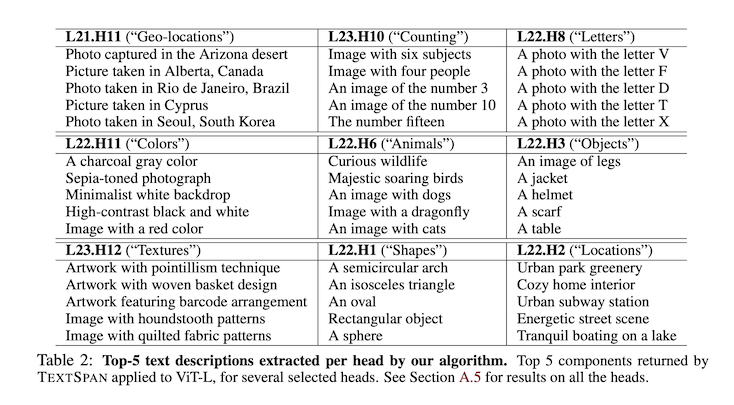

In our task we need to segment cats & dogs on images. So the idea of the solution is going to be the following:
1. Compute CLIP embeddings of all class names
2. Resize image into size (224, 224) (typical size of images that out CLIP takes as input)
3. Compute CLIP embedding of image using CLIP image encoder
4. Compute cosine similarity between image embedding and all the text embeddings, get the class with highest similarity (i.e. do zero-shot classsification). That's how we determine what type of cat/dog is on the current image.
5. Find attention head of CLIP image encoder that reacts to the cats and dogs. We'll use validation set for that.
6. For each test image, extract attention map corresponding to this head. This attention map will show regions on the image that this attention head pays attention to.
7. We project this attention map into CLIP embedding space and compute its dot product with embedding of the class from p.4. This will be our resulting heatmap.

So let's go:

First, we need to write the code for extracting attention maps of individial attention heads. We'll do that by defining a Controller class, and inserting this controller into the code of `forward` method of Attention class. The controller will save and process the attention maps for every input image.

Here's the Controller class:

In [17]:
import numpy as np
import torch
import abc
from collections import defaultdict
from typing import Optional, Union, Tuple, List, Callable, Dict, Any
from copy import deepcopy
import torch.nn as nn


class VectorControl(abc.ABC):
    def __init__(self):
        self.num_att_layers = -1
        self.cur_att_layer = 0

    def reset(self):
        self.cur_att_layer = 0

    def between_steps(self):
        return

    @abc.abstractmethod
    def forward (self, vector, um_heads, curr_head):
        raise NotImplementedError

    def __call__(self, vector, num_heads, curr_head):

        vector = self.forward(vector, num_heads, curr_head)
        return vector


class VectorStore(VectorControl):
    def __init__(self, steering_vectors=None, steer=True, steer_only_up=False,
                 alpha=10, beta=2,
                 steer_back=False,
                device='cpu'):
        super(VectorStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.vector_store = defaultdict(dict)
        self.device=device
        self.attn_layer_num = 0

    def reset(self):
        super(VectorStore, self).reset()
        self.step_store = self.get_empty_store()
        self.vector_store = defaultdict(dict)

    @staticmethod
    def get_empty_store():
        return defaultdict(list)

    def forward(self, vector, num_heads, curr_head):


        # save activation (vector)
        self.step_store[curr_head].append(vector)

        if curr_head == num_heads-1:
            self.between_steps()

        return vector

    def between_steps(self):
        self.vector_store[self.cur_att_layer] = self.step_store
        self.step_store = self.get_empty_store()
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers:
            self.cur_att_layer = 0

Now we need to register our VectorStore (controller). To do that, we need to get the code of the `forward` method of the `Attention` class used in our CLIP, and insert controller inside.

To find the `forward` method of the `Attention` class, we need to look at the source code of our CLIP model. To do that, we first need to determine where this source code is located. We can get the path to the source code, if we try to run our model with the invalid input and look at the error message:

In [18]:
model(9)

ValueError: You have to specify pixel_values

If you're working in colab, you probably see that the error was in one of the lines of the file `/usr/local/lib/python3.11/dist-packages/transformers/models/clip/modeling_clip.py`. So we need to search for the code of the Attention class somewhere around `/usr/local/lib/python3.11/dist-packages/transformers/models/clip/` folder.

After we do that, we sould find that the class of the Attention mechanism used in our CLIP is called `CLIPSdpaAttention`, and we should be able to extract the code of its `forward` method. So let's add the controller to it:

In [23]:
def register_vector_control(model, controller):
    def block_forward(self, place_in_unet):
        # re-defining forward function of the CLIPSdpaAttention class
        def forward(
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.Tensor] = None,
            causal_attention_mask: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = False,
        ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
            """Input shape: Batch x Time x Channel"""

            bsz, tgt_len, embed_dim = hidden_states.size()

            # get query proj
            query_states = self.q_proj(hidden_states) * self.scale
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

            proj_shape = (bsz * self.num_heads, -1, self.head_dim)
            query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
            key_states = key_states.view(*proj_shape)
            value_states = value_states.view(*proj_shape)

            src_len = key_states.size(1)
            attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

            if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
                raise ValueError(
                    f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                    f" {attn_weights.size()}"
                )

            # apply the causal_attention_mask first
            if causal_attention_mask is not None:
                if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                    raise ValueError(
                        f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is"
                        f" {causal_attention_mask.size()}"
                    )
                attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + causal_attention_mask
                attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

            if attention_mask is not None:
                if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                    raise ValueError(
                        f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                    )
                attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
                attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

            attn_weights = nn.functional.softmax(attn_weights, dim=-1)

            if output_attentions:
                # this operation is a bit akward, but it's required to
                # make sure that attn_weights keeps its gradient.
                # In order to do so, attn_weights have to reshaped
                # twice and have to be reused in the following
                attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
                attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
            else:
                attn_weights_reshaped = None

            attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

            # ------- ADDING CONTROLLER
            # [bsz * self.num_heads, tgt_len, src_len, 1], [bsz * self.num_heads, 1, src_len, self.head_dim] ->
            # -> [bsz * self.num_heads, tgt_len, src_len, self.head_dim]
            attn_probs_unsqueezed = attn_probs.unsqueeze(-1)*value_states.unsqueeze(1)
            attn_probs_unsqueezed = attn_probs_unsqueezed.view(bsz, self.num_heads, tgt_len, src_len, self.head_dim)

            for idx in range(self.num_heads):
                x = torch.zeros_like(attn_probs_unsqueezed)
                x[:, idx, :, :, :] = attn_probs_unsqueezed[:, idx, :, :, :].detach().clone()
                x = torch.permute(x, (0, 2, 3, 1, 4))
                x = x.reshape(bsz, tgt_len, src_len, embed_dim)
                x = self.out_proj(x[:, 0, :, :]).cpu()
                controller(x, self.num_heads, idx)
            # ------------------------

            # [bsz * self.num_heads, tgt_len, src_len], [bsz * self.num_heads, src_len, self.head_dim] ->
            # -> [bsz * self.num_heads, tgt_len, self.head_dim]
            attn_output = torch.bmm(attn_probs, value_states)

            if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
                raise ValueError(
                    f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                    f" {attn_output.size()}"
                )

            attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
            attn_output = attn_output.transpose(1, 2)

            attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)
            # [bsz, tgt_len, embed_dim]
            attn_output = self.out_proj(attn_output)



            return attn_output, attn_weights_reshaped


        return forward


    def register_recr(net_, count, place_in_unet):
        '''
        registering controller for all the CLIPSdpaAttentions in the model
        '''
        if net_.__class__.__name__ == 'CLIPSdpaAttention':
            net_.forward = block_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    block_count = 0
    sub_nets = model.named_children()
    for net in sub_nets:
        block_count += register_recr(net[1], 0, "down")
        print(block_count)
    controller.num_att_layers = block_count

Let's run this registering function:

In [24]:
controller = VectorStore()
register_vector_control(model.vision_model.encoder, controller)

12


So we see we have 12 Attention layers that we have registered our controller for.

In [25]:
import torch
from torch.nn import functional as F

# getting embeddings of class names
classes = [' '.join(x.lower().split('_')) for x in class_names]
classes_tokenized = processor(text=class_names, images=None, return_tensors="pt", padding=True).to(device)
classes_encoded = model.get_text_features(**classes_tokenized)
classes_encoded = F.normalize(classes_encoded, dim=-1)

Now let's go through the images in val set, compute their segmentation maps using all available attention heads, and compute the IoUs on val set for all attention heads. Then we'll choose the attention head with the biggest IoU on val set and use it to compute segmentation maps on test set.

In [27]:
def binaryMaskIOU(mask1, mask2):
    assert mask1.shape == mask2.shape
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and(mask1==1,  mask2==1))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

In [44]:
from collections import defaultdict
from tqdm import tqdm_notebook
import os
from PIL import Image
import torchvision.transforms as transforms

imgs_path = './cuties/val_imgs/'
masks_path = './cuties/val_masks/'

IoUs = defaultdict(list)
NUM_PATCHES = 224 // 16
heatmaps = []
img_names = []


def compute_heatmap_from_attn(attentions, k, j, cls_emb):

    # we do 1: because token 0 is cls token, and we need attn_maps for image patches only
    attentions_collapse = attentions[k][j][0][:, 1:, :]

    # passing attn_map through post_layernorm and visual_projection layers
    # to project it to the CLIP embedding space
    # so that we can compare it with text embeddings via cosine similarity
    with torch.no_grad():
        attentions_collapse = model.vision_model.post_layernorm(attentions_collapse.to(device))
        attentions_collapse = model.visual_projection(attentions_collapse.to(device))

    # get heatmap via multiplying attentions_collapse with text embeddings
    class_heatmap = attentions_collapse.detach().cpu().numpy() @ cls_emb.unsqueeze(0).T.data.cpu().numpy()  # [b, n, classes]

    # postprocess heatmap
    results = torch.from_numpy(class_heatmap[0].reshape((1, NUM_PATCHES, NUM_PATCHES)))
    Res = torch.nn.functional.interpolate(results[:, np.newaxis],
                                    scale_factor=16,
                                    mode='bilinear').to(device)
    Res = torch.clip(Res, 0, Res.max())

    # threshold between FG and BG is the mean
    Res = (Res - Res.min()) / (Res.max() - Res.min())

    ret = Res.mean()
    Res_1 = Res.gt(ret).type(Res.type())

    heatmap = target_transform(Res_1).data.cpu().numpy()[0][0]
    return heatmap


for img_name in tqdm_notebook(os.listdir(imgs_path)):
    if '.jpg' not in img_name:
        continue
    controller.reset()

    img = Image.open(os.path.join(imgs_path, img_name))
    mask = Image.open(os.path.join(masks_path, img_name.replace('.jpg', '.png')))

    img_shapes = np.array(img).shape[0], np.array(img).shape[1]
    target_transform = transforms.Compose([
        transforms.Resize((img_shapes[0], img_shapes[1]), Image.NEAREST),
    ])

    # passing image through model and gathering attn_maps in controller
    with torch.no_grad():
        inputs = processor(text='', images=img, return_tensors="pt").to(device)
        outputs = model(**inputs, output_hidden_states=True)
    attentions = controller.vector_store

    # encode entire image and compare its embedding to text embeddings to determine the class
    images_encoded = F.normalize(outputs.image_embeds, dim=-1)
    chosen_class_num = (images_encoded.detach().cpu().numpy() @ classes_encoded.T.data.cpu().numpy()).argmax(axis=1)[0]
    chosen_class = class_names[chosen_class_num]
    chosen_class_emb = classes_encoded[chosen_class_num]


    for k in range(12):
        for j in range(12):

            heatmap = compute_heatmap_from_attn(attentions, k, j, chosen_class_emb)
            heatmaps.append(heatmap)
            img_names.append(img_name)

            # calculating and saving IoU
            IoU = binaryMaskIOU(heatmap, np.array(mask)//255)
            IoUs[(k, j)].append((IoU))

<ipython-input-44-766d644b6952>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm_notebook(os.listdir(imgs_path)):


  0%|          | 0/21 [00:00<?, ?it/s]

Calculate mean IoU oer attn head, and sort it:

In [45]:
mean_ious = {}
for key in IoUs.keys():
    mean_ious[key] = np.mean(IoUs[key])

sorted(mean_ious.items(), key=lambda x: x[1], reverse=True)[:10]

[((11, 1), np.float64(0.4929719779326976)),
 ((9, 10), np.float64(0.4774855367615559)),
 ((11, 10), np.float64(0.46382025766542806)),
 ((10, 5), np.float64(0.44476195570578153)),
 ((11, 11), np.float64(0.4443528098852231)),
 ((11, 8), np.float64(0.43170024751724057)),
 ((9, 6), np.float64(0.43058944621441314)),
 ((11, 9), np.float64(0.36184102193917655)),
 ((10, 6), np.float64(0.35218689280503856)),
 ((10, 11), np.float64(0.34851787029559445))]

So we see that our main candidates for "good" attn_heads are (11, 1), (9, 10), (11, 10). Among those, (9, 10) turns out to show best performance on test set (you might try them all and see the score on Kaggle)

Let's use it to calculate seg masks for test set:

In [46]:
imgs_path = './cuties/test_imgs/'

test_heatmaps = []
test_img_names = []

for img_name in tqdm_notebook(os.listdir(imgs_path)):
    if '.jpg' not in img_name:
        continue
    controller.reset()

    img = Image.open(os.path.join(imgs_path, img_name))

    img_shapes = np.array(img).shape[0], np.array(img).shape[1]
    target_transform = transforms.Compose([
        transforms.Resize((img_shapes[0], img_shapes[1]), Image.NEAREST),
    ])

    # passing image through model and gathering attn_maps in controller
    with torch.no_grad():
        inputs = processor(text='', images=img, return_tensors="pt").to(device)
        outputs = model(**inputs, output_hidden_states=True)
    attentions = controller.vector_store

    # encode entire image and compare its embedding to text embeddings to determine the class
    images_encoded = F.normalize(outputs.image_embeds, dim=-1)
    chosen_class_num = (images_encoded.detach().cpu().numpy() @ classes_encoded.T.data.cpu().numpy()).argmax(axis=1)[0]
    chosen_class = class_names[chosen_class_num]
    chosen_class_emb = classes_encoded[chosen_class_num]

    heatmap = compute_heatmap_from_attn(attentions, 9, 10, chosen_class_emb)
    test_heatmaps.append(heatmap)
    test_img_names.append(img_name)


<ipython-input-46-90ccbad0da36>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm_notebook(os.listdir(imgs_path)):


  0%|          | 0/1000 [00:00<?, ?it/s]

We can look at resulting masks:

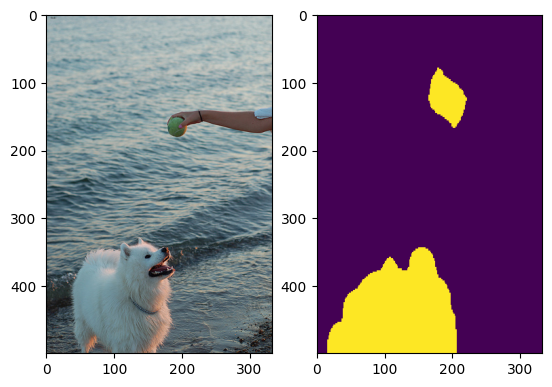

In [52]:
import matplotlib.pyplot as plt

# change this to view sifferent images
NUM_VIS_IMG = 2
f, axes = plt.subplots(1,2)
axes[0].imshow(np.array(Image.open(os.path.join(imgs_path,
                                                test_img_names[NUM_VIS_IMG]
                                               )
                                  )
                       )
              )
axes[1].imshow(test_heatmaps[NUM_VIS_IMG])

And now we can make a submission:

In [49]:
from io import BytesIO
import base64
import pandas as pd

def image_to_base64(image: Image.Image, fmt: str = "PNG") -> str:
    """ Конвертирует картинку PIL.Image в base64 (текстовый формат). """
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

ids = []
b64 = []

for img_name, seg_mask in zip(test_img_names, test_heatmaps):
    ids.append(img_name[:-4]) # get rid og .jpg part
    mask = Image.fromarray(255*seg_mask)
    b64.append(image_to_base64(mask.convert("L")))

pred_pd = pd.DataFrame({"img_id": [int(id_) for id_ in ids], "mask": b64})
pred_pd.to_csv('test_submission.csv', index=False)

This gives ~0.485 on public & private sets in Kaggle.

Ideas on further improvement:
- Better post-processing of resulting maps (they're still kind of noisy and rough). For example, finding biggest connected component would help
- Combining outputs of some good attention heads instead of using only one